# 課題001：高解像度の画像への変換（超解像）

## 1. はじめに

このプロジェクトでは、低解像度画像（CIFAR-10）を高解像度に変換する**超解像タスク**に取り組む。
本実装では、SRCNN（Super-Resolution Convolutional Neural Network）をPyTorchで構築し、アップサンプリング画像と比較して、どの程度復元できるかを確認する。

---

## 2. 使用ライブラリとデータセットの準備


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


Files already downloaded and verified


---

## 3. モデルの構築（SRCNN）
中間層を3層以上持つCNN構造で、超解像を実現する。


In [3]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=5, padding=2)
        )

    def forward(self, x):
        return self.model(x)


---

## 4. 学習処理
損失関数にはMSELoss、最適化にはAdamを使用。


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SRCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [5]:
losses = []  # 学習開始前にリストを初期化

n_epochs = 5
for epoch in range(n_epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        
        # ダウンサンプリング → アップサンプリング
        low_res = F.interpolate(images, scale_factor=0.5, mode='bilinear')
        low_res_upsampled = F.interpolate(low_res, scale_factor=2, mode='bilinear')

        # 推論と損失計算
        preds = model(low_res_upsampled)
        loss = criterion(preds, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    # 1エポックごとの平均Loss
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/5, Loss: 0.0062
Epoch 2/5, Loss: 0.0027
Epoch 3/5, Loss: 0.0026
Epoch 4/5, Loss: 0.0025
Epoch 5/5, Loss: 0.0025


---

## 5. 学習曲線の可視化


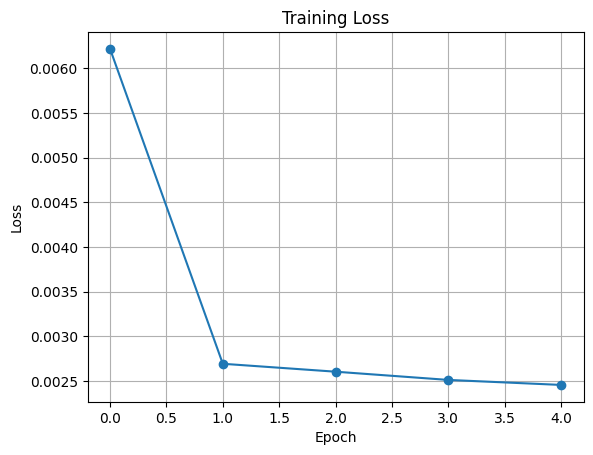

In [6]:
plt.plot(losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


---

## 6. 結果の可視化と比較
入力（Upsampled）、予測（SRCNN）、元画像（Ground Truth）の3枚を比較。


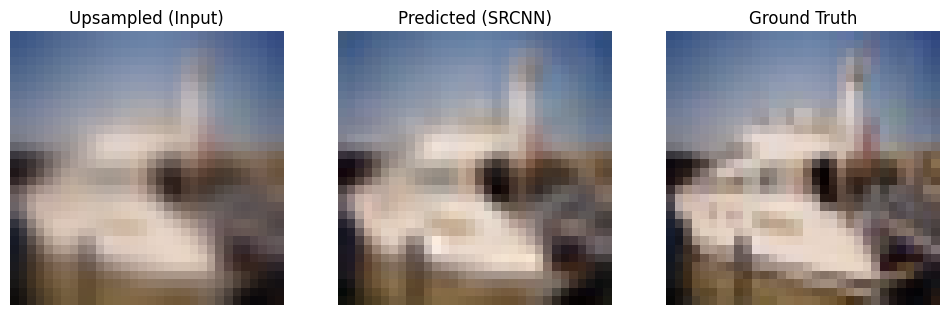

In [7]:
def show_image(img_tensor, title):
    img = img_tensor.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(np.clip(img, 0, 1))
    plt.title(title)
    plt.axis('off')

data_iter = iter(train_loader)
images, _ = next(data_iter)
images = images.to(device)
low_res = F.interpolate(images, scale_factor=0.5, mode='bilinear')
low_res_upsampled = F.interpolate(low_res, scale_factor=2, mode='bilinear')
output = model(low_res_upsampled)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
show_image(low_res_upsampled[0], "Upsampled (Input)")
plt.subplot(1, 3, 2)
show_image(output[0], "Predicted (SRCNN)")
plt.subplot(1, 3, 3)
show_image(images[0], "Ground Truth")
plt.show()


---

## 7. 結果の考察

- SRCNNにより、アップサンプリング画像と比較して、エッジや細部がより明瞭に再構成されている。
- 学習の進行に伴いLossが安定して減少しており、モデルは画像復元の特徴を学習している。
- CIFAR-10は元々解像度が低いため、回復できる情報には限界がある。
- 今後の改善案：
    - 残差ブロックの導入（ResNet的手法）
    - より高解像度のデータセットでの再学習
    - Perceptual LossやSSIMの導入による視覚的品質の向上

---

## 8. まとめ

- 本プロジェクトでは、深層学習を用いた超解像において、SRCNNを実装し一定の成果を得た。
- 今後はさらなる精度向上のためにモデルの高度化と評価指標の導入が必要。

---
